# x264 Configurations analysis
## **RQ**: Is it possible to provide a minimal partial configuration for x264 using existing knowledge from previous experimentations ?
>Partial refers to the fact that the configuration space is already defined (all the configuration options have been identified)
but you only know the value of some of these options. - **Paul Temple** -

## Methods
- We use data generated by Luc Lesoil during is thesis on Deep Variability [https://github.com/llesoil/input_sensitivity]
- Data consists of **280797** compression tests **201** x264 configurations x **1397** videos from UGC Dataset [https://media.withyoutube.com/]
- We choose to use 2 features as optimization targets
  
    1. Size of the output video (compression level)
    2. Compute time (compression efficiency)

- Building pareto front for each video of the dataset, based on size and compute time
- Exploring pareto fronts to search for configurations that are common to different (if not all) categories of videos.


In [1]:
!pip install seaborn scipy scikit-learn torch numpy pandas matplotlib plotly plotnine patchworklib


import sklearn as skl
import torch
import seaborn as sb
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import *
import plotnine as pn
from plotnine import *
from functools import *
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from scipy.stats import pareto
import os
pd.set_option("display.max_rows", None, "display.max_columns", None)


# Loading an x264 run that contains the 201 configurations
> We turn categories into numbers and apply data normalization

In [2]:
data_df=pd.read_csv("../input_sensitivity/data/x264/Animation_1080P-0c4f.csv")

> Helsp to convert elapsedtime into numerical values. Yes we could have just dropped it since etime exists but I realized it a bit too late :)

In [3]:
def time_to_ms(t):
    ms = t.split('.')
    s = ms[0].split(':')
    res = int(s[0])*60000+int(s[1])*1000+int(ms[1])*10
    return res

In [4]:
data_df['deblock']=pd.Categorical(data_df.deblock)
data_df['analyse']=pd.Categorical(data_df.analyse)
data_df['direct']=pd.Categorical(data_df.direct)
data_df['me']=pd.Categorical(data_df.me)

#turn category to numbers
LE = LabelEncoder()
data_df['deblock_codes'] = LE.fit_transform(data_df['deblock'])
data_df['analyse_codes'] = LE.fit_transform(data_df['analyse'])
data_df['direct_codes'] = LE.fit_transform(data_df['direct'])
data_df['me_codes'] = LE.fit_transform(data_df['me'])

time = data_df["elapsedtime"].values
time=list(map(lambda x: time_to_ms(x),time))
data_df['elapsedtime']=pd.DataFrame(time)

In [5]:
data=data_df.drop(["deblock","analyse","direct","me"],axis=1)
all_cols=data.columns
conf_ids = data_df[['configurationID']]

scaler = StandardScaler()
scaler.fit(data)
norm_data = scaler.transform(data)
imp = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=-1)
imp.fit(norm_data)
norm_data = imp.transform(norm_data)
norm_data=pd.DataFrame(norm_data,columns=all_cols)
#norm_data

# Are the configurations various enough in terms of 2D space representation ?
1. Keep configuration features only (remove config ids and results)
2. Apply TSNE projection (dimension reduction) on it, and append non-normalized features from original data for further analysis (because we want it to be readable not a soup of floats)
> IMHO it is quite good

In [6]:
cols=norm_data.drop(["configurationID","size","usertime","systemtime","cpu","frames","fps","kbs","etime"],axis=1).columns

proj = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=2,n_iter=5000).fit_transform(norm_data)
proj = pd.DataFrame(proj,columns=['x','y'])
proj['configurationID']= conf_ids
proj[['cabac', 'ref', 'subme','mixed_ref', 'me_range', 'trellis', '8x8dct', 'fast_pskip','chroma_qp_offset', 'bframes', 'b_pyramid', \
      'b_adapt','weightb', 'open_gop', 'weightp', 'scenecut', 'rc_lookahead', 'mbtree','qpmax', 'aq-mode', 'deblock_codes','analyse_codes', \
      'direct_codes', 'me_codes']] = data_df[['cabac', 'ref', 'subme','mixed_ref', 'me_range', 'trellis', '8x8dct', 'fast_pskip','chroma_qp_offset',\
                                              'bframes', 'b_pyramid', 'b_adapt','weightb', 'open_gop', 'weightp', 'scenecut', 'rc_lookahead', 'mbtree',\
                                              'qpmax', 'aq-mode', 'deblock_codes','analyse_codes', 'direct_codes', 'me_codes']]

projxmin,projxmax,projymin,projymax=proj['x'].min(),proj['x'].max(),proj['y'].min(),proj['y'].max()

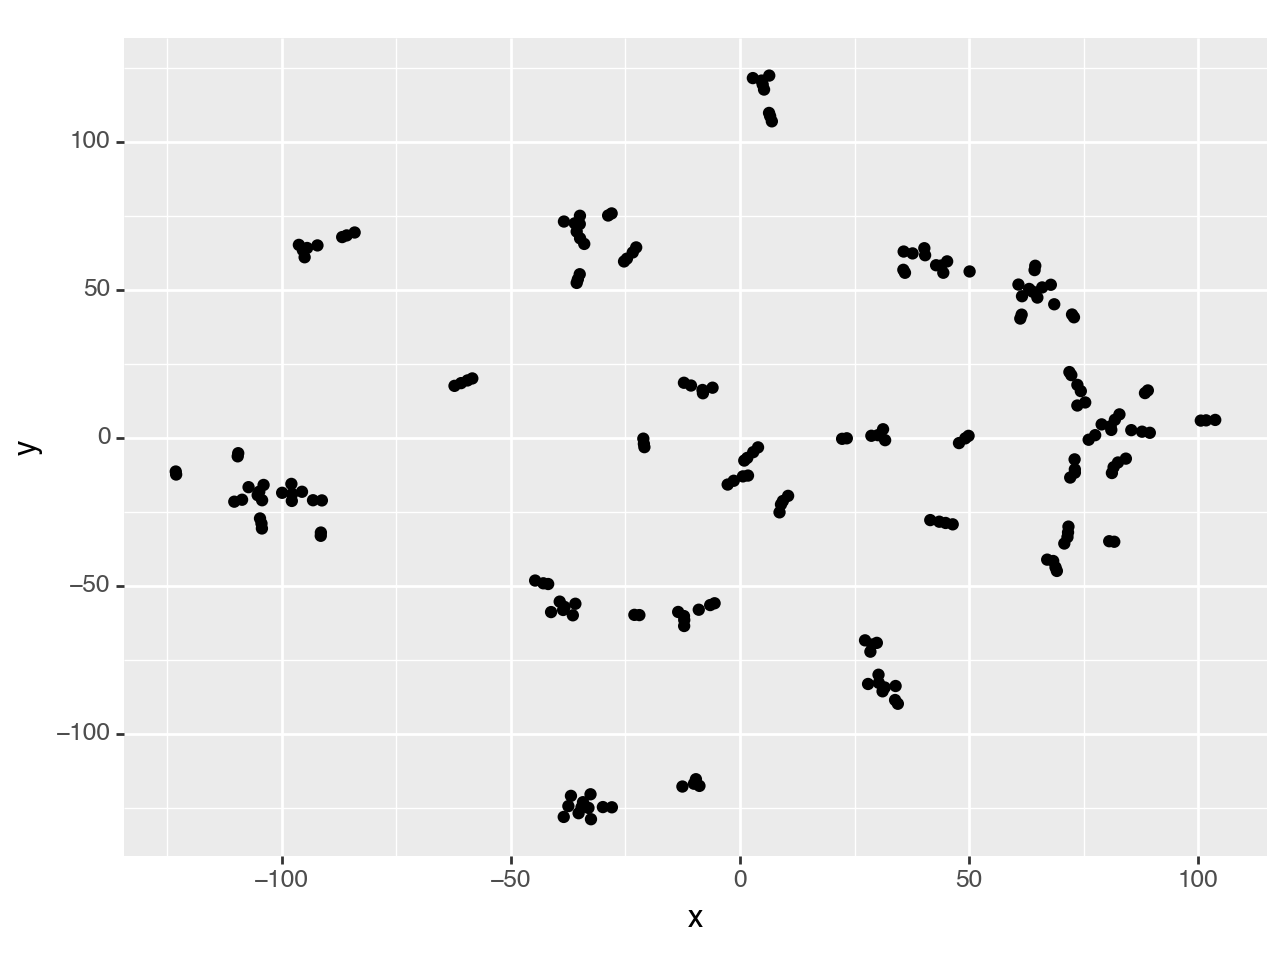

<Figure Size: (640 x 480)>

In [7]:
(ggplot(proj)
 +aes(x='x',y='y')#,color='factor(bframes)')
 +xlim(projxmin,projxmax)
 +ylim(projymin,projymax)
 + geom_point()
)

# Building the pareto fronts of all runs.
1. We need to normalize targets by min-max scaling them
2. We compute the pareto fronts
3. We analyze the results

## Pareto fronts analysis
1. We build a score for configurations based on the mean of both targets standardized values
2. We choose to extract "top of paretos" with scores < 0.2 (**somehow arbitrary atm**)
3. Using all the top paretos we group by videos categories
4. We try to find "perfect" configurations that are in the top paretos and that cross all the video categories 

In [8]:
target1,target2 ="etime","size"

categories=['Animation', 'CoverSong', 'Gaming', 'HDR', 'HowTo', 'Lecture',
       'LiveMusic', 'LyricVideo', 'MusicVideo', 'NewsClip', 'Sports',
       'TelevisionClip', 'VerticalVideo', 'Vlog']


> Just show the min and max values (Useless in terms of code)

## Pareto front utilites

1. Let i:=1
2. Add Ai to the Pareto frontier.
3. Find smallest j>i such that value(Aj)>value(Ai)
4. If no such j exists, stop. Otherwise let i:=j
   and repeat from step 2.


In [9]:
def pareto_front(df:pd.DataFrame,target1:str,target2:str,id_col:str,maximize:bool=True) -> pd.DataFrame:
    data_df = df.sort_values(by=target1,ascending=maximize)
    target1_values = data_df[target1].to_numpy()
    target2_values = data_df[target2].to_numpy()
    id_col_values= data_df[id_col].to_numpy()
    triplets = list(zip(id_col_values,zip(target2_values,target1_values)))
    
    i=0
    front = []
    #prev_optimum=1.0
    while i < len(triplets):
        optimum = triplets[i]
        found = False
        if i+1 < len(triplets):
            for j in range(i+1,len(triplets)):
                if triplets[j][1][0] <= optimum[1][0]:
                    optimum = triplets[j]
                    #prev_optimum=triplets[j][1][0]
                    i=j
                    found = True
                    break
            if len(front) == 0:
                front+=[optimum]
            if optimum[1][0] <= front[-1][1][0]:
                front+=[optimum]
        if not found:
            i+=1
            
    pareto_id_col = list(map(lambda x: x[0],front))
    pareto_target2 = list(map(lambda x: x[1][0],front))
    pareto_target1 = list(map(lambda x: x[1][1],front))
    pareto_df = pd.DataFrame()
    pareto_df[id_col]=pareto_id_col
    pareto_df[target1]=pareto_target1
    pareto_df[target2]=pareto_target2

    pareto_IDs = list(pareto_df[id_col])
    IDs = list(map(lambda x: x[0],filter(lambda x: x if x not in pareto_IDs else None,list(df[[id_col]].drop_duplicates().values))))
    pareto_data = data_df[data_df[id_col].isin(pareto_IDs)].copy()
    pareto_data["pareto_front"]=True
    npareto_data = data_df[data_df[id_col].isin(IDs)].copy()
    npareto_data["pareto_front"]=False
    pareto_front_data = pd.concat([pareto_data,npareto_data])

    return pareto_front_data

def standardize_targets(df:pd.DataFrame,target1:str,target2:str)-> pd.DataFrame:
    scaler = MinMaxScaler()
    sample = df[[target1,target2]]
    scaler.fit(sample)
    sample=pd.DataFrame(scaler.transform(sample),columns=[target1,target2])
    df.drop([target1,target2], axis=1)
    df[target1]=sample[target1]
    df[target2]=sample[target2]
    return df
    
#Extract top of pareto front (values in lower left hand corner) for which the average of normalized targets is below a given threshold
def extract_pareto_top(df:pd.DataFrame, target1:str,target2:str, threshold:float=0.2)-> pd.DataFrame:
    std_pareto=standardize_targets(df,target1,target2)
    std_pareto_front=std_pareto[std_pareto.pareto_front == True].copy()
    std_pareto_front["score"]=(std_pareto_front[target1] + std_pareto_front[target2])/2
    return std_pareto_front[std_pareto_front.score <= threshold]

# extract configurations that are present at least 'tops_count' times in a pareto front dataset
def count_tops(df,tops_count=10):
    df["counter"]=1
    pre_out=df[["configurationID","counter"]].groupby("configurationID").count().sort_values("counter")
    pre_out=pre_out[pre_out["counter"]>tops_count]
    return pre_out

In [10]:
def pareto_rank_numpy(data):
    """Calculate the pareto front rank for each row in the numpy array."""
    unassigned = np.ones(len(data), dtype=bool)
    ranks = np.zeros(len(data), dtype=np.int32)
    front = 0

    while np.any(unassigned):
        front += 1

        # Adapted from https://github.com/QUVA-Lab/artemis/blob/peter/artemis/general/pareto_efficiency.py
        is_efficient = np.ones(data.shape[0], dtype=bool)
        is_efficient[~unassigned] = False
        for i, c in enumerate(data):
            if is_efficient[i]:
                # Keep any point with a lower cost or all cost exactly equal (for ties)
                is_efficient[is_efficient] = np.logical_or(
                    np.any(data[is_efficient] < c, axis=1),
                    np.all(data[is_efficient] == c, axis=1),
                )
                # is_efficient[i] = True  # And keep self

        ranks[is_efficient] = front
        unassigned[is_efficient] = False

    return ranks


def pareto_rank(pd_group):
    return pd.Series(pareto_rank_numpy(pd_group.values), index=pd_group.index)

In [11]:
pareto = pareto_front(standardize_targets(data_df,"etime","size"),"etime","size","configurationID")


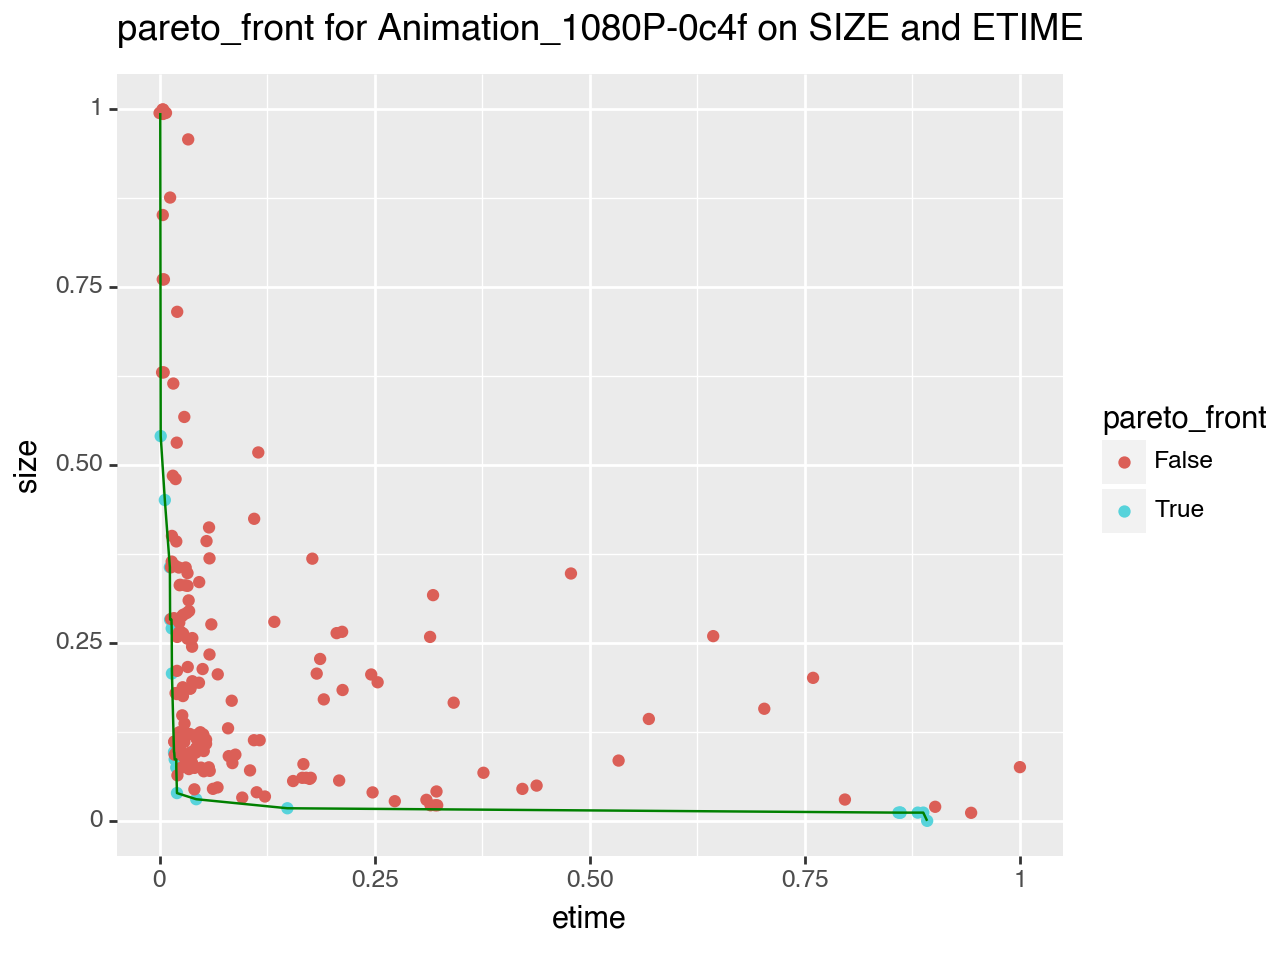

<Figure Size: (640 x 480)>

In [12]:
 (ggplot(pareto)
 +aes(x='etime',y='size',color="pareto_front")
 +labs(title="pareto_front for Animation_1080P-0c4f on SIZE and ETIME")
 + geom_point()
  #+ stat_smooth(pareto[pareto['pareto_front']])
  + geom_line(pareto[pareto['pareto_front']],color='green')
)

# Observation of spatial proximity of top configurations
> Using pre-computed TSNE 2D configurations projection

In [13]:
pareto_top = extract_pareto_top(pareto,"etime","size")
pareto_top_confs = list(pareto_top.index)

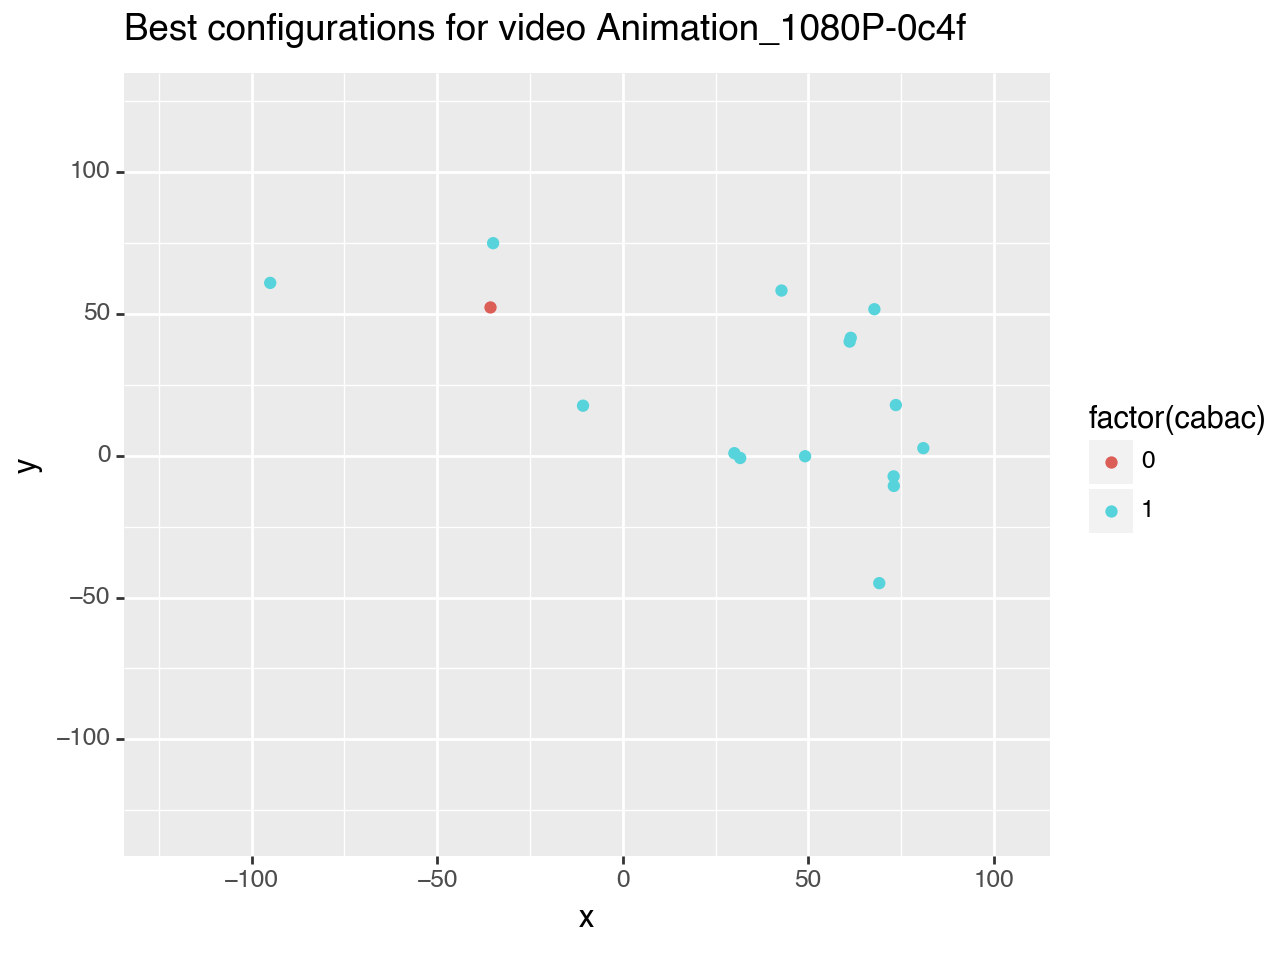

<Figure Size: (640 x 480)>

In [14]:
idx=proj[proj["configurationID"].isin(pareto_top_confs)]
idx=idx.index

(ggplot(proj.iloc[idx])
 +aes(x='x',y='y',color='factor(cabac)')
 +xlim(projxmin,projxmax)
 +ylim(projymin,projymax)
 +labs(title='Best configurations for video Animation_1080P-0c4f')
 + geom_point()
)

# Now let's roll over the whole dataset
1. Compute pareto front of every run of x264 in the dataset
2. Extract top configurations for all the runs
3. Group by video category and count top configurations
4. Try to find at least 1 configuration that is in the top configurations of all categories

In [15]:
all_files = os.listdir('../input_sensitivity/data/x264')
all_files = list(filter(lambda x:os.path.isfile('../input_sensitivity/data/x264/'+x),all_files))
#list of all pareto fronts
li_paretos={}
#list of all pareto fronts tops
li_tops = []
#Dict of pareto fronts of each video category
li_cat={}

for c in categories:
    cat_data = []
    for filename in all_files:
        if c in filename:
            df = pd.read_csv('../input_sensitivity/data/x264/'+filename, index_col=None, header=0)
            df['vidID']=filename.split('.')[0]
            pareto = pareto_front(standardize_targets(df.copy(),"etime","size"),"etime","size","configurationID")
            li_paretos.update({filename:pareto.copy()})
            extracted_pareto=extract_pareto_top(pareto,"etime","size",threshold=0.2)
            li_tops +=[extracted_pareto]
            cat_data+=[extracted_pareto]
    li_cat.update({c:cat_data})
    
len(all_files)

1397

In [16]:
len(list(li_paretos.keys()))

1308

/opt/homebrew/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


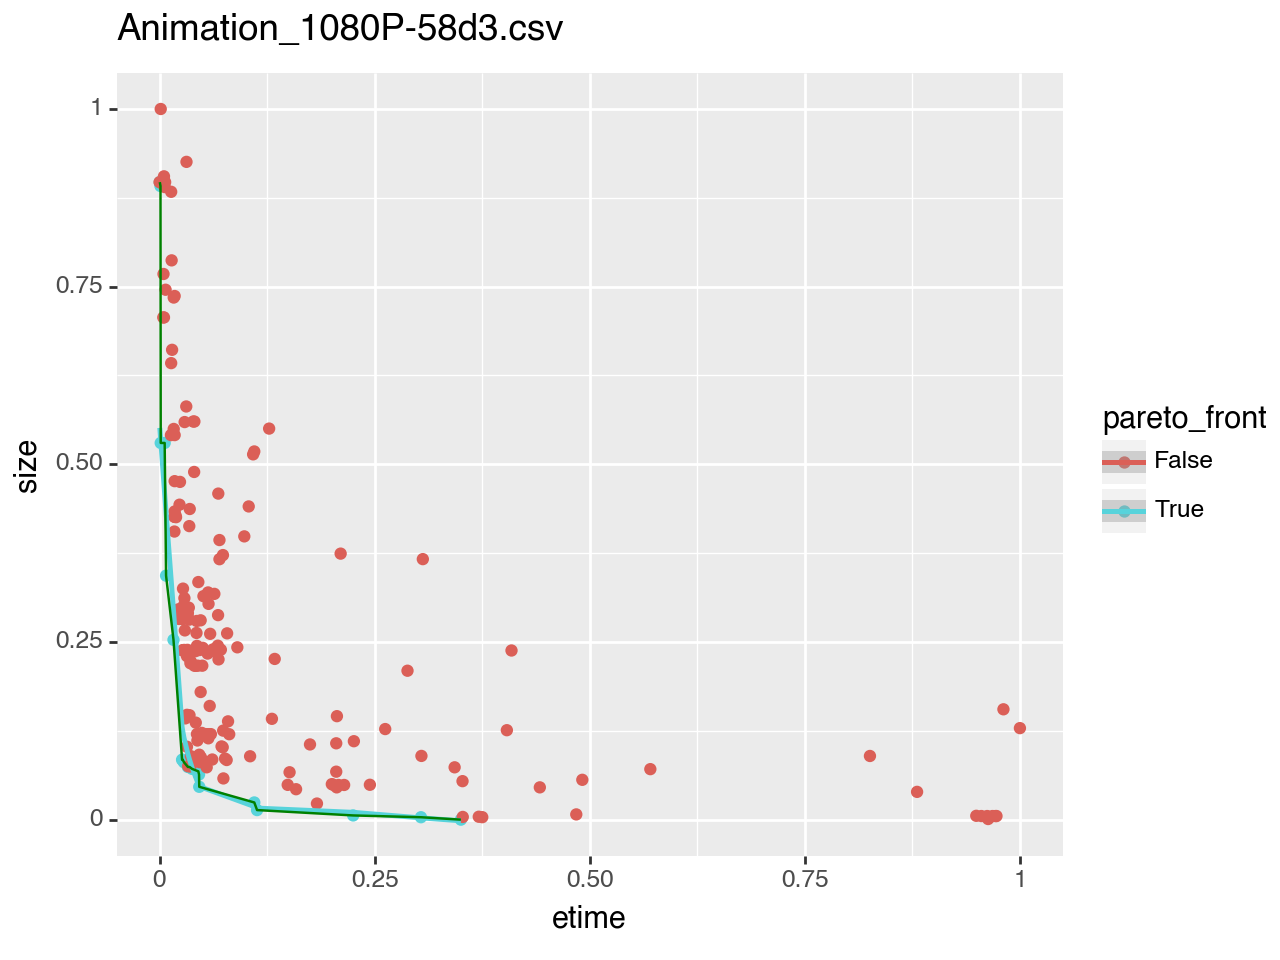

<Figure Size: (640 x 480)>

In [17]:
pareto_sample=list(li_paretos.keys())[20]
show_sample = li_paretos.get(pareto_sample)
(ggplot(show_sample)
 +aes(x='etime',y='size',color="pareto_front")
 +labs(title=pareto_sample)
 + geom_point()
 + stat_smooth(show_sample[show_sample['pareto_front']])
 + geom_line(show_sample[show_sample['pareto_front']],color='green')
)

In [18]:
# A dict of configurations ID and number of their occurence in each video category
tops_categ = {}
for c in categories:
    df=pd.concat(li_cat.get(c), axis=0, ignore_index=True)
    cat_tops = count_tops(df,tops_count=15)
    tops_categ.update({c:cat_tops})
    

In [27]:
#tops_categ


# Traverse tops_categ and fill a dict in which keys are configurations IDs and values the name of categories for which the categories is in the top configs
``` python
{184: ['Gaming', 'HDR', 'Lecture', 'Vlog'],
70: ['HowTo', 'Gaming', 'HowTo', 'Lecture'],
...}
```

In [20]:
common_best=set()
commonalities={}
done=set()
for c in set(categories)-done:
    done.add(c)
    df=list(tops_categ.get(c).index)
    df.reverse()
    print(c,'@')
    for top_conf in df:
        present=set()
        present.add(c)
        for c2 in categories:
            if top_conf in list(tops_categ.get(c2).index):
                #print(top_conf)
                present.add(c2)
                #print(present)
    
        last_data = commonalities.get(top_conf)
        if last_data is not None:
            s1 = present.union(last_data)
            commonalities.update({top_conf:s1})
        else:
            commonalities.update({top_conf:present})

HowTo @
Lecture @
LiveMusic @
Animation @
TelevisionClip @
VerticalVideo @
NewsClip @
Gaming @
HDR @
Sports @
MusicVideo @
LyricVideo @
CoverSong @
Vlog @


# A configuration is 'perfect' if it is in the top confs of all the video categories
> In other words if the len of the values of a given configuration == len(categories) then the configuration is 'perfect'

In [30]:
common_confs = list(commonalities.keys())
perfect_confs =[]
for conf in common_confs:
    print(len(commonalities.get(conf)))
    if(len(commonalities.get(conf))==len(categories)):
        print(conf)
        perfect_confs+=[conf]

13
11
7
7
9
9
6
11
10
10
10
8
6
7
1
3
2
2
4
4
2
4
3
3
1
3
2
1
1
2
2
1
1
1


In [28]:
common_confs

[11,
 3,
 63,
 72,
 19,
 30,
 36,
 39,
 38,
 37,
 23,
 18,
 71,
 17,
 43,
 13,
 24,
 15,
 42,
 2,
 40,
 130,
 34,
 20,
 195,
 65,
 64,
 183,
 68,
 25,
 14,
 155,
 41,
 50]

In [22]:
idx=proj[proj["configurationID"].isin(perfect_confs)]
idx=idx.index

(ggplot(proj.iloc[idx])
 +aes(x='x',y='y',color='factor(cabac)')
 +xlim(projxmin,projxmax)
 +ylim(projymin,projymax)
 +labs(title='Perfect configurations')
 + geom_point()
)

<Figure Size: (640 x 480)>

# Perfect configurations features

In [23]:
data_df[data_df["configurationID"].isin(perfect_confs)]

Empty DataFrame
Columns: [configurationID, cabac, ref, deblock, analyse, me, subme, mixed_ref, me_range, trellis, 8x8dct, fast_pskip, chroma_qp_offset, bframes, b_pyramid, b_adapt, direct, weightb, open_gop, weightp, scenecut, rc_lookahead, mbtree, qpmax, aq-mode, size, usertime, systemtime, elapsedtime, cpu, frames, fps, kbs, etime, deblock_codes, analyse_codes, direct_codes, me_codes]
Index: []

# Explore how close those perfect configurations are in terms of scoring
> The lower the better

In [24]:
whole_dataset = pd.concat(li_tops, axis=0, ignore_index=True)
perfect_dataset = whole_dataset[whole_dataset["configurationID"].isin(perfect_confs)]
perfect_scores = perfect_dataset[['configurationID','score']].groupby("configurationID").mean().sort_values("score")
perfect_scores_stddev=perfect_dataset[['configurationID','score']].groupby("configurationID").std()
perfect_scores_stddev=perfect_scores_stddev.rename(columns={"score":"std_dev"})
perfect_scores_idx = list(perfect_scores.index)
perfect_scores.merge(perfect_scores_stddev,on="configurationID")

Empty DataFrame
Columns: [score, std_dev]
Index: []

# Observe features of 3 best among the best. Are those features that close ?

In [25]:
data_df[data_df["configurationID"].isin(perfect_scores_idx[:3])]

Empty DataFrame
Columns: [configurationID, cabac, ref, deblock, analyse, me, subme, mixed_ref, me_range, trellis, 8x8dct, fast_pskip, chroma_qp_offset, bframes, b_pyramid, b_adapt, direct, weightb, open_gop, weightp, scenecut, rc_lookahead, mbtree, qpmax, aq-mode, size, usertime, systemtime, elapsedtime, cpu, frames, fps, kbs, etime, deblock_codes, analyse_codes, direct_codes, me_codes]
Index: []

# Partial features :

## CONSTANT
- cabac = 1
- ref = 16
- me_range = 24
- trellis = 2
- 8x8dict = 1
- b_pyramid = 2.0
- b_adapt = 2.0
- direct = spatial
- weightb = 1.0
- open_gop = 0.0
- weightp = 2
- scenecut = 40.0
- rc_lookahead = 60.0
- mbtree = 1
- qpmax = 69
- aq-mode = 1
  
## VARIABLE
- deblock = [1:0:0 | 0:0:0]
- analyse = 0x3:0x[113 | 133]
- me = [umh | tesa]
- subme = [10 | 11]
- mixed_ref = [0 | 1]
- fast_pskip = [0 | 1]
- chroma_qp_offset = [-2 | 0]
- bframes = [8 | 16]

# Next

> We look forward to apply this method on other datasets built by Luc, and maybe write a paper on this matter